## ASF Hyp3 workflow and MintPy Time Series Analysis
#### *Created 25 March 2024*

M Tan (mtan@usgs.gov)

General references:

> ASF Hyp3 documentation: https://github.com/ASFHyP3

> ASF Open SAR Lab: https://github.com/ASFOpenSARlab/

> MintPy documentation: https://github.com/insarlab/MintPy

> For MT original compilation of workflow, including ARIA-tools: *ariaDownload_mintpy_workflow.ipynb*. Note, contains deprecated packages and not debugged.

***

#### <font color='green'>Download+prep data for MintPy options:</font>

##### ASF Hyp3

1. Download data from ASF Vertex website
    > tutorial: https://storymaps.arcgis.com/stories/68a8a3253900411185ae9eb6bb5283d3
2. Prepare HyP3 InSAR Stack for MintPy
    > tutorial: https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/Prepare_HyP3_InSAR_Stack_for_MintPy.ipynb

##### Tropospheric corrections (GACOS)

1. Download data from GACOS
    > website: http://www.gacos.net/
2. Unzip GACOS data 

#### <font color='orange'>Time series using MintPy</font>
1. smallbaselineApp.py
    > tutorial: https://github.com/ASFOpenSARlab/opensarlab_NISAR_EA_Workshop_2024_1_Recipe_Book/blob/main/HyP3/MintPy_sbas_permafrost_Alaska.ipynb
2. Visualization / convert to geotiffs

***

In [1]:
# Import packages and modules for all workflow

import os, copy
import glob
import shutil
import sys
from osgeo import gdal,osr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import opensarlab_lib as asfn
from typing import List, Union, Dict
from pathlib import Path
import re
from collections import Counter

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

In [2]:
from datetime import datetime, timedelta
import ipywidgets as widgets
from itertools import chain
import json
import requests
from tqdm.auto import tqdm

import pandas
from rasterio.warp import transform_bounds

from hyp3_sdk import Batch, HyP3

from IPython.display import Markdown
from IPython.display import display
from IPython.display import clear_output

%matplotlib widget

In [3]:
# Verify gdal version (should be >= 3)

!gdalinfo --version

GDAL 3.8.4, released 2024/02/08


In [4]:
# Import asf and hyp3 packages

import asf_search as asf
import hyp3_sdk as sdk

In [5]:
# Set working directory

work_dir = '/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/'

default_dir = os.getcwd()

print("default dir: ", default_dir)
print("working dir: ", work_dir)

default dir:  /Users/mtan/src/scripts
working dir:  /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/


#### Step 1: Download data
Utilize ASF Vertex online tool

1. query for location, dates, track, path

2. select a scene to be used as SBAS reference scene <-- this is the key to generate InSAR_GAMMA files for downlod!

3. add the InSAR_GAMMA products to the "Submit Products" queue

    inputs:

    > looks: 20x4 {gives you 80m x 80m resolution}

    > phase filter: 0.6

    > water mask: YES

    > DEM: YES

    > Incidence angle maps: YES

    > Look vectors: YES

4. after the products are ready, download the products to your specified directory

*Optionally,* Download tropospheric data from GACOS.net

###### *ERA5 data is also supported, but due to long queues GACOS is recommended*

1. query for location

2. input dates (utilize dates given in ASF SBAS website), 20 maximum

3. download and unzip data to the directory you will run MintPy processing within

    <div class="alert alert-block alert-info">
    <b>Tip:</b> submit products to the Hyp3 and GACOS queue in the evening to run overnight.
    </div>

In [ ]:
#Check on status of Hyp3 job

hyp3 = sdk.HyP3()
rtc_jobs = hyp3.find_jobs(name='TR116_PA124')
rtc_jobs = hyp3.watch(rtc_jobs)

#### Step 2: Prepare_HyP3_InSAR_Stack_for_MintPy

In [6]:
# Confirm Presence of a DEM, Azimuth Angle Map, and Incidence Angle Map

dems = list(glob.glob(os.path.join(work_dir, '*/*dem*.tif'), recursive=True))
az_angle_maps = list(glob.glob(os.path.join(work_dir, '*/*lv_phi*.tif'), recursive=True))
inc_angle_maps = list(glob.glob(os.path.join(work_dir, '*/*lv_theta*.tif'), recursive=True))

if len(dems) > 0:
    print("Success: Found at least 1 DEM.")
else:
    raise FileNotFoundError("Failed to find at least 1 DEM. \
    \nYou will not be able to successfully run a MintPy time-series unless you reorder your HyP3 project \
with DEMS or provide one from another source.")
    
if len(az_angle_maps) > 0:
    print("Success: Found at least 1 Azimuth Angle Map.")
else:
    raise FileNotFoundError("Failed to find at least 1 Azimuth Angle Map. \
    \nYou will not be able to successfully run a MintPy time-series unless your reorder your HyP3 project \
with 'Include Look Vectors' option selected.")
    
if len(inc_angle_maps) > 0:
    print("Success: Found at least 1 Incidence Angle Map.")
else:
    raise FileNotFoundError("Failed to find at least 1 Incidence Angle Map. \
    \nYou will not be able to successfully run a MintPy time-series unless your reorder your HyP3 project \
with 'Include Inc. Angle Map' option selected.")

Success: Found at least 1 DEM.
Success: Found at least 1 Azimuth Angle Map.
Success: Found at least 1 Incidence Angle Map.


In [8]:
# functions to project all tiffs to Predominant UTM

def get_projection(img_path: Union[Path, str]) -> Union[str, None]:
    """
    Takes: a string or posix path to a product in a UTM projection

    Returns: the projection (as a string) or None if none found
    """
    img_path = str(img_path)
    try:
        info = gdal.Info(img_path, format='json')['coordinateSystem']['wkt']
    except KeyError:
        return None
    except TypeError:
        raise FileNotFoundError

    regex = 'ID\["EPSG",[0-9]{4,5}\]\]$'
    results = re.search(regex, info)
    if results:
        return results.group(0).split(',')[1][:-2]
    else:
        return None

def get_projections(tiff_paths: List[Union[Path, str]]) -> Dict:
    """
    Takes: List of string or posix paths to geotiffs
    
    Returns: Dictionary key: epsg, value: number of tiffs in that epsg 
    """
    epsgs = []
    for p in tiff_paths:
        epsgs.append(get_projection(p))

    epsgs = dict(Counter(epsgs))
    return epsgs

def get_res(tiff):
    tiff = str(tiff)
    f =  gdal.Open(tiff)
    return f.GetGeoTransform()[1] 

def get_no_data_val(pth):
    pth = str(pth)
    f = gdal.Open(str(pth))
    if f.GetRasterBand(1).DataType > 5:
        no_data_val = f.GetRasterBand(1).GetNoDataValue()
        return np.nan if no_data_val == None else f.GetRasterBand(1).GetNoDataValue()
    else:
        return 0

In [9]:
fnames = list(glob.glob(os.path.join(work_dir, '*/*.tif'), recursive=True))
fnames.sort()
epsgs = get_projections(fnames)
predominant_epsg = None if len(epsgs) == 1 else max(epsgs, key=epsgs.get)

if predominant_epsg:
    for pth in fnames:
        src_SRS = get_projection(str(pth))
        res = get_res(pth)
        if src_SRS != predominant_epsg:
            res = get_res(pth)
            no_data_val = get_no_data_val(pth)
    
            temp = pth.parent/f"temp_{pth.stem}.tif"
            pth.rename(temp)

            warp_options = {
                "dstSRS":f"EPSG:{predominant_epsg}", "srcSRS":f"EPSG:{src_SRS}",
                "targetAlignedPixels":True,
                "xRes":res, "yRes":res,
                "dstNodata": no_data_val
            }
            gdal.Warp(str(pth), str(temp), **warp_options)
            temp.unlink()

In [11]:
print(predominant_epsg)
print(epsgs)

None
{'32637': 180}


In [13]:
amp = list(glob.glob(os.path.join(work_dir, '*/*_amp*.tif'), recursive=True))
max_extents = asfn.get_max_extents(amp)
xmin, ymin, xmax, ymax = transform_bounds(int(asfn.get_projection(str(amp[0]))), 3857, *max_extents)
max_extents = [xmin, ymin, xmax, ymax]

common_extents = asfn.get_common_coverage_extents(amp)
xmin, ymin, xmax, ymax = transform_bounds(int(asfn.get_projection(str(amp[0]))), 3857, *common_extents)
common_extents = [xmin, ymin, xmax, ymax]

print(max_extents)
print(common_extents)

[4052117.9813674735, 4391906.040398534, 4423426.10344351, 4689893.751669064]
[4052533.3053152715, 4392116.540660603, 4423014.40668668, 4689687.806420311]


In [154]:
from pathlib import Path
from typing import List, Union
from osgeo import gdal


def get_common_overlap(file_list: List[Union[str, Path]]) -> List[float]:
    """Get the common overlap of  a list of GeoTIFF files
    
    Arg:
        file_list: a list of GeoTIFF files
    
    Returns:
         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y
         corner coordinates of the common overlap
    """
    
    corners = [gdal.Info(str(dem), format='json')['cornerCoordinates'] for dem in file_list]

    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]

from pathlib import Path
from typing import List, Union

def clip_hyp3_products_to_common_overlap(data_dir: Union[str, Path], overlap: List[float]) -> None:
    """Clip all GeoTIFF files to their common overlap
    
    Args:
        data_dir:
            directory containing the GeoTIFF files to clip
        overlap:
            a list of the upper-left x, upper-left y, lower-right-x, and lower-tight y
            corner coordinates of the common overlap
    Returns: None
    """

    
    files_for_mintpy = ['_water_mask.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']

    for extension in files_for_mintpy:

        for file in glob.glob(os.path.join('/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/**/', f'*{extension}'), recursive=True):
            p = os.path.dirname(file)
            dst_file = os.path.join(p, f'{os.path.splitext(file)[0]}_clipped{os.path.splitext(file)[1]}')

            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)

In [155]:
files = glob.glob(os.path.join(work_dir, '*/*_dem.tif'), recursive=True)

overlap = get_common_overlap(files)
print(overlap)

[274440.0, 4291960.0, 563640.0, 4060360.0]


In [156]:
clip_hyp3_products_to_common_overlap(work_dir, overlap)

In [15]:
# Remove any subset scenes containing no data

fnames = list(glob.glob(os.path.join(work_dir, '*/*.tif'), recursive=True))
fnames = [str(f) for f in fnames]
fnames.sort()

removed = []
for f in fnames:
    if not "dem" in str(f):
        raster = gdal.Open(f)
        if raster:
            band = raster.ReadAsArray()
            if np.count_nonzero(band) < 1:
                Path(f).unlink()
                removed.append(f)

if len(removed) == 0:
    print("No Geotiffs were removed")
else:
    print(f"{len(removed)} GeoTiffs removed:")
    for f in removed:
        print(f)

No Geotiffs were removed


### MintPy Time Series Analysis

1. smallbaselineApp

You can run every step in smallbaselineApp.py with one call, or individually:


>load_data

>modify_network

>reference_point

>quick_overview

>invert_network

>correct_troposphere

>correct_topography

>residual_RMS

>reference_date

>velocity

>google_earth


Skipped steps include:


>correct_unwrap_error

>correct_LOD

>correct_SET

>deramp

>hdfeos5

In [6]:
# Import packages

%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
from cartopy import crs as ccrs
from mintpy.utils import readfile, utils as ut, plot as pp
from mintpy.cli import view, tsview, plot_network, plot_transection
from mintpy.view import prep_slice, plot_slice
#from workflows import utils

plt.rcParams.update({'font.size': 12})

In [7]:
# utils function

def write_config_file(out_file, CONFIG_TXT, mode='a'): 
    """Write configuration files for MintPy to process ARIA sample products"""
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))

In [8]:
CONFIG_TXT = '''# vim: set filetype=cfg:
mintpy.load.processor        = hyp3
##---------interferogram datasets
mintpy.load.unwFile          = /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/*/*_unw_phase_clipped.tif
mintpy.load.corFile          = /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/*/*_corr_clipped.tif
##---------geometry datasets:
mintpy.load.demFile          = /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/*/*_dem_clipped.tif
mintpy.load.incAngleFile     = /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/*/*_lv_theta_clipped.tif
mintpy.load.azAngleFile      = /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/*/*_lv_phi_clipped.tif
mintpy.load.waterMaskFile    = /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/*/*_water_mask_clipped.tif
mintpy.troposphericDelay.method = gacos
'''
work_dir = '/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/'
config_file = os.path.join(work_dir, 'mintpy_config_119_v3.txt')
write_config_file(config_file, CONFIG_TXT, mode='w')

write configuration to file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/mintpy_config_119_v3.txt


In [9]:
# Load data

work_dir = '/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/'
os.chdir(work_dir)
print('Go to work directory:', work_dir)

!smallbaselineApp.py mintpy_config_119_v3.txt --dostep load_data

Go to work directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/
MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-02 10:45:55.992028--
Current directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config_119_v3
Go to work directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
copy default template file /Users/mtan/miniconda3/envs/mintpy/lib/python3.11/site-packages/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /Users/mtan/Library/CloudStorage/OneDrive

In [10]:
inputs_path = '/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/inputs/'
!ls $inputs_path
!info.py $inputs_path/ifgramStack.h5

geometryGeo.h5           mintpy_config_119_v3.txt
ifgramStack.h5           smallbaselineApp.cfg
******************** Basic File Info ************************
file name: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/inputs/ifgramStack.h5
file type: ifgramStack
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                             4
  ANTENNA_SIDE                       -1
  AZIMUTH_PIXEL_SIZE                 56.4
  BANDS                              1
  CENTER_LINE_UTC                    55569.076488
  DATA_TYPE                          float32
  DATE12                             230228-230312
  EARTH_RADIUS                       6370264.9229
  EPSG                               32637
  FILE_LENGTH                        2895
  FILE_PATH                          /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/S1AA_20230228T152607_20230312T152607_VVP012_INT80_G_weF_78E6/S1AA_20

In [11]:
# Modify network

!smallbaselineApp.py mintpy_config_119_v3.txt --dostep modify_network

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-02 10:47:00.269640--
Current directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config_119_v3
Go to work directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
read custom template file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/mintpy_config_119_v3.txt
update default template based on input custom template
No new option value found, skip updating /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg
read default 

In [107]:
# Reference point selection
## option 1: run reference_point step using MintPy default reference point selection (random)
## option 2: run reference point step using ref_x and ref_y. Must set in smallbaseline.cfg file first!
## option 3: re-run reference point step using MintPy non-default reference point selection (in this case, random of highest coherence {maxCoherence})

#OPTION 1
#!smallbaselineApp.py mintpy_config_119_v3.txt --dostep reference_point

#OPTION 2
!reference_point.py /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/inputs/ifgramStack.h5 -t /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg -c /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/avgSpatialCoh.h5 --method manual --force

#OPTION 3
#!reference_point.py /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/inputs/ifgramStack.h5 -t /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg -c /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/avgSpatialCoh.h5 --method maxCoherence --force

--------------------------------------------------
reading reference info from template: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg
input reference point in lat/lon: (4109822.0, 375826.0)
input reference point in y/x: (2276, 1267)
--------------------------------------------------
calculate the temporal average of unwrapPhase in file /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/inputs/ifgramStack.h5 ...
[==================================================] lines 2895/2895 
Add/update ref_x/y attribute to file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/inputs/ifgramStack.h5
{'REF_Y': '2276', 'REF_X': '1267', 'REF_LAT': '4109840.0', 'REF_LON': '375840.0'}
touch avgSpatialCoh.h5


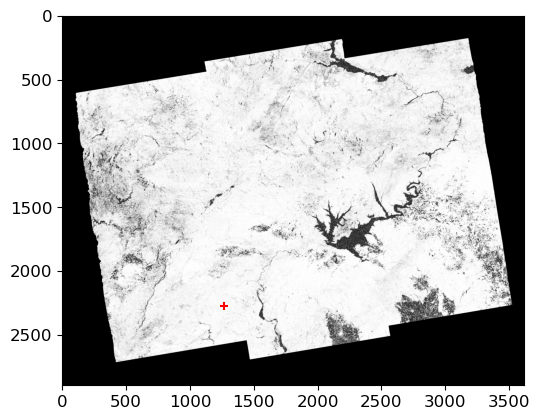

In [108]:
# Plot reference point in x/y on average coherence geotiff

import rasterio as rs
from matplotlib import pyplot

def plot_refpt(geotiff_path, xref, yref):
    raster = rs.open(geotiff_path)
    array = raster.read()
    imgplot = pyplot.imshow(array[0], vmin=0, vmax=1, cmap='grey')
    imgplot = plt.scatter(xref, yref, marker='+', color='r')

plot_refpt('/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/S1AA_20230920T152616_20231002T152616_VVP012_INT80_G_weF_1247/S1AA_20230920T152616_20231002T152616_VVP012_INT80_G_weF_1247_corr_clipped.tif', xref=1267, yref=2276)

view.py /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/inputs/ifgramStack.h5 unwrapPhase-* -v -6 6 --zero-mask --noaxis --noverbose --figsize 10 8 --noverbose --nodisplay
view.py /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/inputs/ifgramStack.h5 unwrapPhase-* -v -6 6 --zero-mask --noaxis --noverbose --figsize 10 8


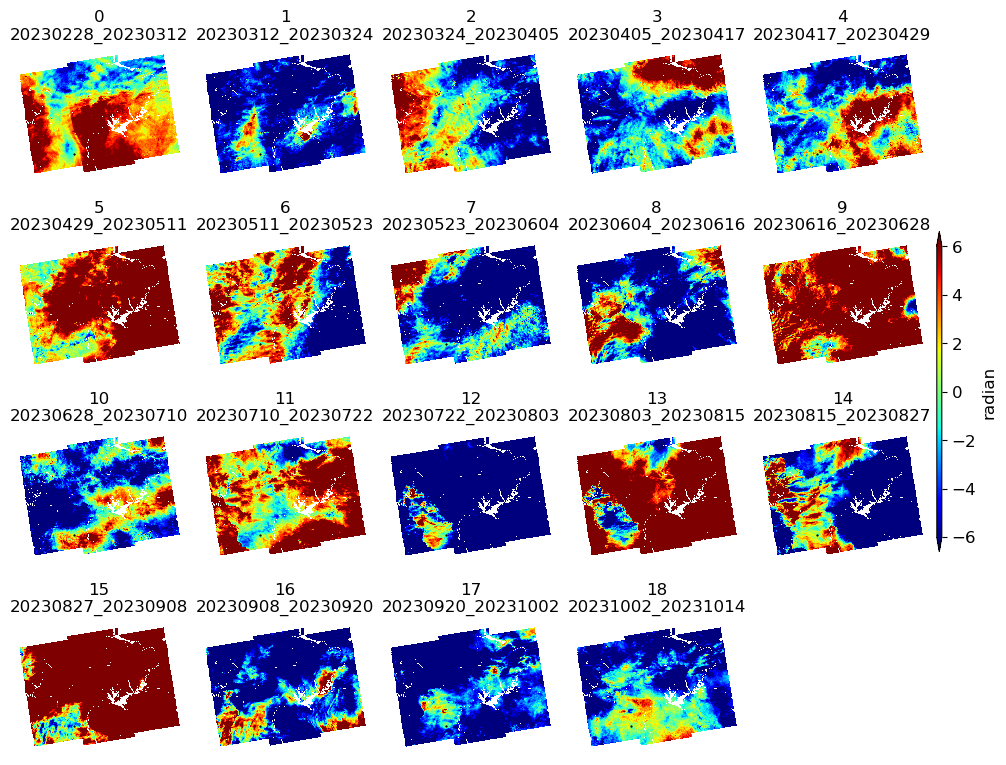

In [109]:
# View stacks of interferograms from the ifgramStack.h5 file

scp_args = '/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/inputs/ifgramStack.h5 unwrapPhase-* -v -6 6 --zero-mask --noaxis --noverbose --figsize 10 8'
view.main(scp_args.split() + ['--noverbose', '--nodisplay'])
%matplotlib inline
view.main(scp_args.split())

In [110]:
# Invert network ~28 minutes for 19 ifg pairs

!smallbaselineApp.py mintpy_config_119_v3.txt --dostep invert_network

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-03 13:27:51.160316--
Current directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config_119_v3
Go to work directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
read custom template file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/mintpy_config_119_v3.txt
update default template based on input custom template
No new option value found, skip updating /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg
copy smallbaselineApp.cfg     to inputs   directory for backup.
copy smallbaselineApp.cfg   

view.py /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/timeseries.h5 -v -3 3 --noaxis --figsize 10 6 --noverbose --nodisplay
run view.py in MintPy version 1.5.3, date 2023-11-23
input file is timeseries file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/timeseries.h5 in float32 format
file size in y/x: (2895, 3615)
num of datasets in file timeseries.h5: 20
datasets to exclude (0):
[]
datasets to display (20):
['timeseries-20230228', 'timeseries-20230312', 'timeseries-20230324', 'timeseries-20230405', 'timeseries-20230417', 'timeseries-20230429', 'timeseries-20230511', 'timeseries-20230523', 'timeseries-20230604', 'timeseries-20230616', 'timeseries-20230628', 'timeseries-20230710', 'timeseries-20230722', 'timeseries-20230803', 'timeseries-20230815', 'timeseries-20230827', 'timeseries-20230908', 'timeseries-20230920', 'timeseries-20231002', 'timeseries-20231014']
data   coverage in y/x: (0, 0, 3615, 2895)
subset coverage in y/x: (0, 0, 3615, 28

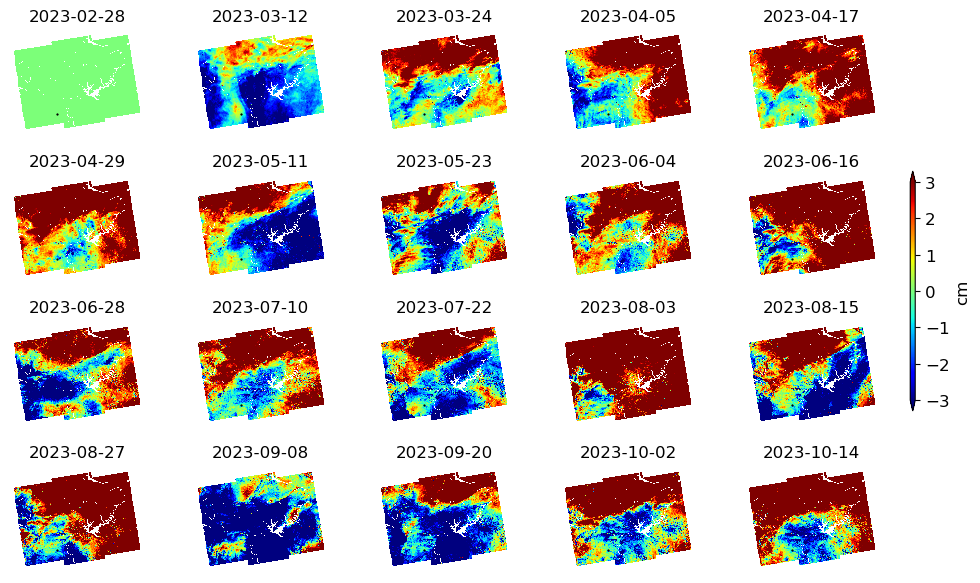

In [111]:
ts_h5 = '/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/timeseries.h5'

# Show the inverted phase history
scp_args = f'{ts_h5} -v -3 3 --noaxis --figsize 10 6'
view.main(scp_args.split() + ['--noverbose', '--nodisplay'])
%matplotlib inline
view.main(scp_args.split())

In [87]:
# ERA5 tropospheric corrections

tropo_choice = asfn.select_parameter(["Perform Tropospheric Correction Step",
                                      "Skip Tropospheric Correction Step",
                                      "Delete Outputs of a Previous (possibly interrupted) Troposheric Correction and Rerun",
                                      "Delete Outputs of a Previous Troposheric Correction and Skip Troposheric Correction Now"])

display(tropo_choice)

RadioButtons(layout=Layout(min_width='800px'), options=('Perform Tropospheric Correction Step', 'Skip Troposph…

In [88]:
def set_troposhperic_correction_mintpy(config_path, method):
    config_path = Path(config_path)
    with open(config_path, 'r') as f:
        config = f.readlines()    
    config_update = config
    
    for i, l in enumerate(config):
        no_comment = l.split("#")[0]
        present = False
        if "mintpy.troposphericDelay.method=" in "".join(no_comment.split()):
            config_update[i] = f"mintpy.troposphericDelay.method = {method}"
            present = True
            break     
    if not present:
        config_update.append(f"\nmintpy.troposphericDelay.method = {method}")

    config_str = ""
    for l in config_update:
        config_str = f"{config_str}{l}"
    
    with open(config_path, 'w') as f:
        f.write(config_str)

In [89]:
# Tropospheric corrections

mint_path = '/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/'
config_path = '/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/mintpy_config_119_v3.txt'

correct_tropo = "Perform" in tropo_choice.value or "Rerun" in tropo_choice.value
era5_path = f'{mint_path}/ERA5'
timeseries_era5_path = f'{mint_path}/timeseries_ERA5.h5'
inputs_era5_path = f'{mint_path}/inputs/ERA5.h5'

if "Delete" in tropo_choice.value:
    for f in [timeseries_era5_path, inputs_era5_path]:
        try:
            os.unlink(f)
        except FileNotFoundError:
            pass
    try:
        shutil.rmtree(era5_path)
    except FileNotFoundError:
        pass

if correct_tropo:
    set_troposhperic_correction_mintpy(config_path, "gacos")
    !smallbaselineApp.py $config_path --work-dir {mint_path} --dostep load_data
    !smallbaselineApp.py $config_path --work-dir {mint_path} --dostep correct_troposphere
else:
    set_troposhperic_correction_mintpy(config_path, "no")
    !smallbaselineApp.py $config_path --work-dir {mint_path} --dostep load_data


MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-03 12:21:29.221765--
Current directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config_119_v3
Go to work directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
read custom template file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/mintpy_config_119_v3.txt
update default template based on input custom template
No new option value found, skip updating /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg


<div class="alert alert-block alert-warning">
<b>Notice:</b> You may get a ValueError: cannot convert float NaN to integer

In this case, open tropo_gacos.py (/Users/mtan/miniconda3/envs/mintpy/lib/python3.11/site-packages/mintpy/tropo_gacos.py) and comment out lines 162-168:

                # check if output file is fully written
                with h5py.File(tropo_file, 'r') as f:
                    if np.all(f['timeseries'][-1,:,:] == 0):
                        flag = 'run'
                        print('3) output file is NOT fully written.')
                    else:
                        print('3) output file is fully written.')
</div>

In [ ]:
"""
Full ValueError:

1) output file exists and is newer than all ZTD files.
2) output file has the same len/wid as the geometry file and contains all dates
3) output file is NOT fully written.
run or skip: run
--------------------------------------------------
create HDF5 file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/inputs/GACOS.h5 with w mode
create dataset  : date       of |S8                       in size of (20,)                with compression = None
create dataset  : timeseries of <class 'numpy.float32'>   in size of (20, 2895, 3615)     with compression = None
close  HDF5 file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/inputs/GACOS.h5
read incidenceAngle from file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/inputs/geometryGeo.h5
/Users/mtan/miniconda3/envs/mintpy/lib/python3.11/site-packages/skimage/transform/_warps.py:184: RuntimeWarning: divide by zero encountered in scalar divide
  zoom_factors = [1 / f for f in factors]
/Users/mtan/miniconda3/envs/mintpy/lib/python3.11/site-packages/scipy/ndimage/_interpolation.py:821: RuntimeWarning: invalid value encountered in scalar multiply
  [int(round(ii * jj)) for ii, jj in zip(input.shape, zoom)])
Traceback (most recent call last):
  File "/Users/mtan/miniconda3/envs/mintpy/bin/tropo_gacos.py", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Users/mtan/miniconda3/envs/mintpy/lib/python3.11/site-packages/mintpy/cli/tropo_gacos.py", line 114, in main
    run_tropo_gacos(inps)
  File "/Users/mtan/miniconda3/envs/mintpy/lib/python3.11/site-packages/mintpy/tropo_gacos.py", line 251, in run_tropo_gacos
    calculate_delay_timeseries(
...
  File "/Users/mtan/miniconda3/envs/mintpy/lib/python3.11/site-packages/scipy/ndimage/_interpolation.py", line 821, in <listcomp>
    [int(round(ii * jj)) for ii, jj in zip(input.shape, zoom)])
         ^^^^^^^^^^^^^^
ValueError: cannot convert float NaN to integer
"""

view.py /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG//timeseries_GACOS.h5 -v -3 3 --noaxis --figsize 10 6 --noverbose --nodisplay
run view.py in MintPy version 1.5.3, date 2023-11-23
input file is timeseries file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/timeseries_GACOS.h5 in float32 format
file size in y/x: (2895, 3615)
num of datasets in file timeseries_GACOS.h5: 20
datasets to exclude (0):
[]
datasets to display (20):
['timeseries-20230228', 'timeseries-20230312', 'timeseries-20230324', 'timeseries-20230405', 'timeseries-20230417', 'timeseries-20230429', 'timeseries-20230511', 'timeseries-20230523', 'timeseries-20230604', 'timeseries-20230616', 'timeseries-20230628', 'timeseries-20230710', 'timeseries-20230722', 'timeseries-20230803', 'timeseries-20230815', 'timeseries-20230827', 'timeseries-20230908', 'timeseries-20230920', 'timeseries-20231002', 'timeseries-20231014']
data   coverage in y/x: (0, 0, 3615, 2895)
subset coverage in y

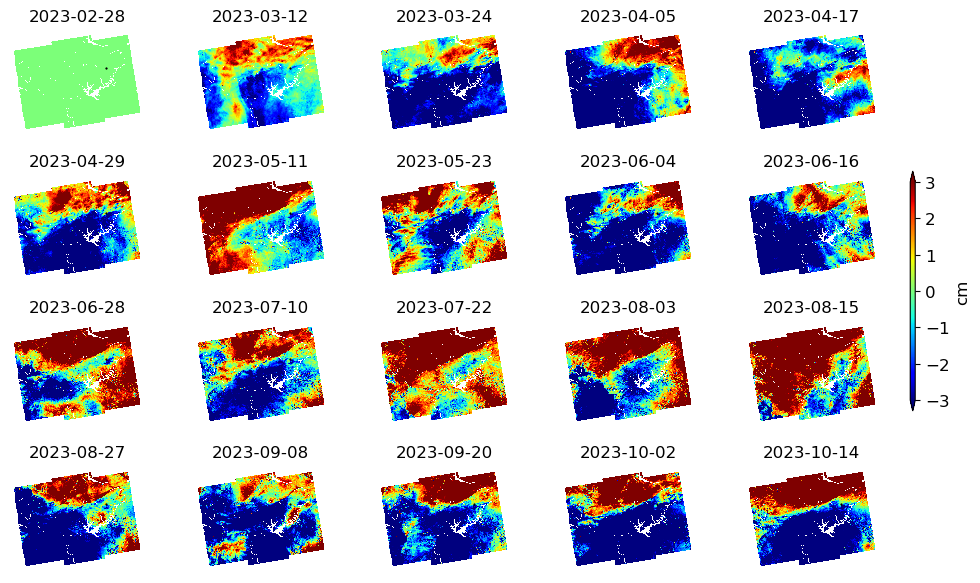

In [90]:
# Display the tropospheric-corrected time series

scp_args = f'{mint_path}/timeseries_GACOS.h5 -v -3 3 --noaxis --figsize 10 6'
view.main(scp_args.split() + ['--noverbose', '--nodisplay'])
%matplotlib inline
view.main(scp_args.split())

In [91]:
# Deramp
# Correct topography
# ~15 min

mint_path = '/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/'
config_path = '/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/mintpy_config_119_v3.txt'

!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep deramp
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep correct_topography

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-03 12:22:27.510809--
Current directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config_119_v3
Go to work directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
read custom template file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/mintpy_config_119_v3.txt
update default template based on input custom template
No new option value found, skip updating /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg
read default template file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg


******************** step - deramp *********

In [92]:
mint_path = '/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG'
ts_ERA5_demErr_h5 = f'{mint_path}/timeseries_GACOS_demErr.h5'

# Calculate the temporal derivative of time-series.
!temporal_derivative.py $ts_ERA5_demErr_h5     

calculating the temporal derivative of timeseries file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/timeseries_GACOS_demErr.h5
reading timeseries data
calculate the 1st derivative of timeseries data
create timeseries HDF5 file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/timeseries_GACOS_demErr_1stDiff.h5 with w mode
create dataset /timeseries of float32    in size of (20, 2895, 3615) with compression=None
create dataset /dates      of |S8        in size of (20,)
create dataset /bperp      of float32    in size of (20,)
finished writing to /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/timeseries_GACOS_demErr_1stDiff.h5


view.py /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/timeseries_GACOS_demErr.h5 -v -1 1 --noaxis --figsize 10 8 --noverbose --nodisplay
run view.py in MintPy version 1.5.3, date 2023-11-23
input file is timeseries file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/timeseries_GACOS_demErr.h5 in float32 format
file size in y/x: (2895, 3615)
num of datasets in file timeseries_GACOS_demErr.h5: 20
datasets to exclude (0):
[]
datasets to display (20):
['timeseries-20230228', 'timeseries-20230312', 'timeseries-20230324', 'timeseries-20230405', 'timeseries-20230417', 'timeseries-20230429', 'timeseries-20230511', 'timeseries-20230523', 'timeseries-20230604', 'timeseries-20230616', 'timeseries-20230628', 'timeseries-20230710', 'timeseries-20230722', 'timeseries-20230803', 'timeseries-20230815', 'timeseries-20230827', 'timeseries-20230908', 'timeseries-20230920', 'timeseries-20231002', 'timeseries-20231014']
data   coverage in y/x: (0, 0, 3615, 2895)


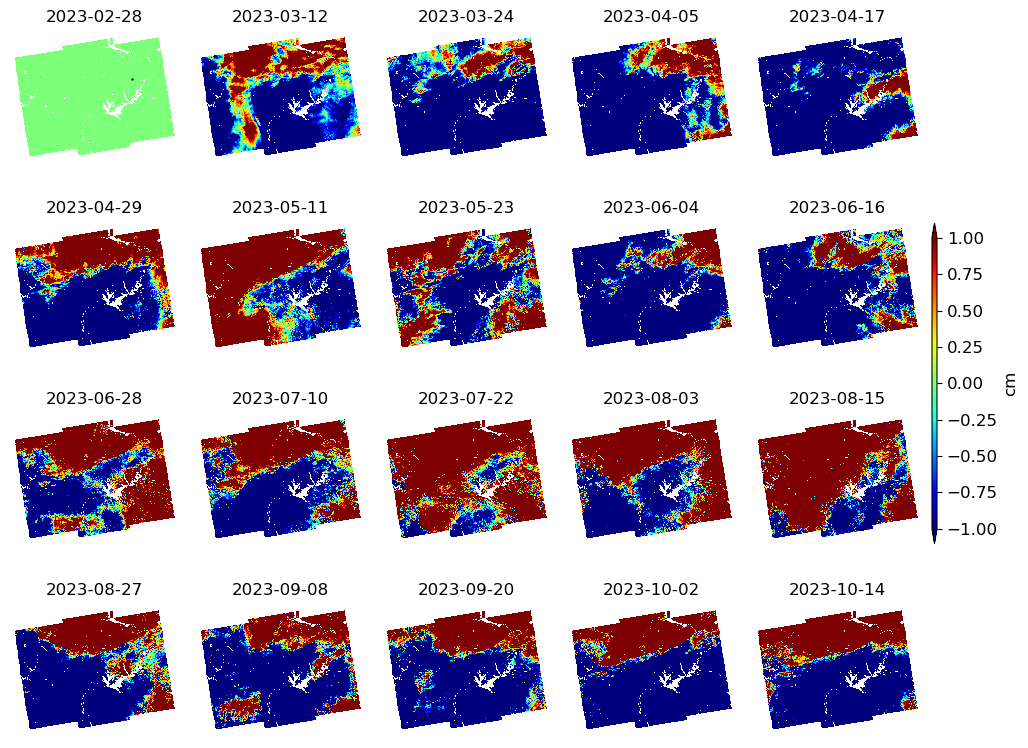

In [93]:
# Display the deformation time series

scp_args = f'{ts_ERA5_demErr_h5} -v -1 1 --noaxis --figsize 10 8'
view.main(scp_args.split() + ['--noverbose', '--nodisplay'])
%matplotlib inline
view.main(scp_args.split())

view.py /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/timeseries_GACOS_demErr_1stDiff.h5 -v -3 3 --noaxis --figsize 10 8 --noverbose --nodisplay
run view.py in MintPy version 1.5.3, date 2023-11-23
input file is timeseries file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/timeseries_GACOS_demErr_1stDiff.h5 in float32 format
file size in y/x: (2895, 3615)
num of datasets in file timeseries_GACOS_demErr_1stDiff.h5: 20
datasets to exclude (0):
[]
datasets to display (20):
['timeseries-20230228', 'timeseries-20230312', 'timeseries-20230324', 'timeseries-20230405', 'timeseries-20230417', 'timeseries-20230429', 'timeseries-20230511', 'timeseries-20230523', 'timeseries-20230604', 'timeseries-20230616', 'timeseries-20230628', 'timeseries-20230710', 'timeseries-20230722', 'timeseries-20230803', 'timeseries-20230815', 'timeseries-20230827', 'timeseries-20230908', 'timeseries-20230920', 'timeseries-20231002', 'timeseries-20231014']
data   coverage in 

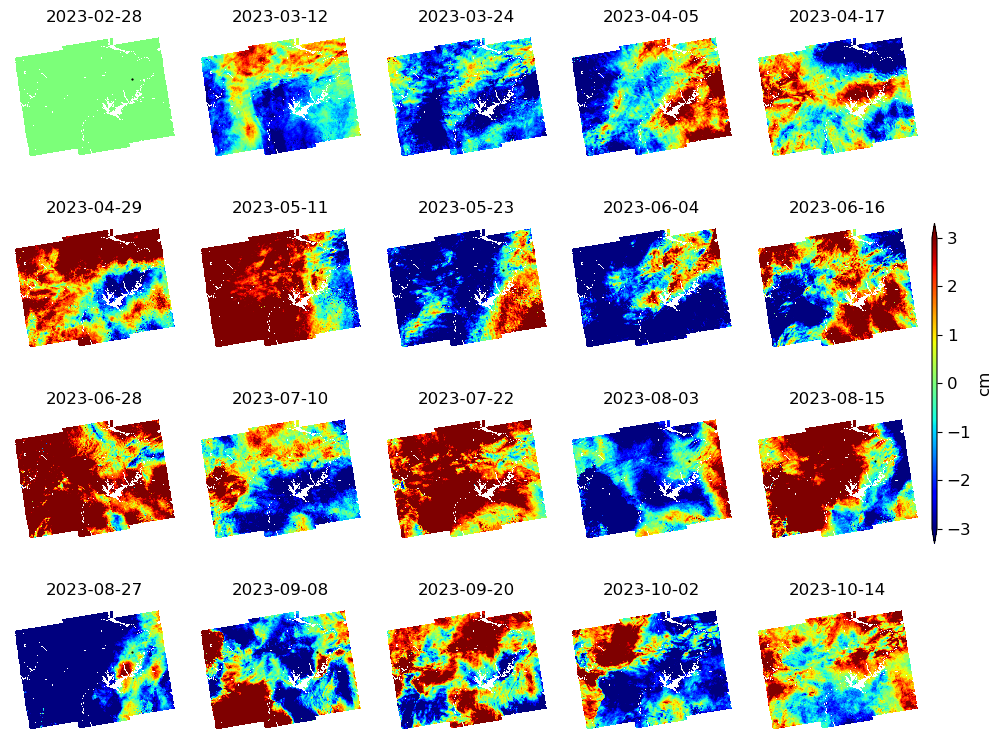

In [94]:
# Display the the temporal derivative of deformation time series

scp_args = f'{mint_path}/timeseries_GACOS_demErr_1stDiff.h5 -v -3 3 --noaxis --figsize 10 8'
view.main(scp_args.split() + ['--noverbose', '--nodisplay'])
%matplotlib inline
view.main(scp_args.split())

In [95]:
# Residual RMS

!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep residual_RMS

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-03 12:50:46.259178--
Current directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
Run routine processing with smallbaselineApp.py on steps: ['residual_RMS']
Remaining steps: ['reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config_119_v3
Go to work directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
read custom template file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/mintpy_config_119_v3.txt
update default template based on input custom template
No new option value found, skip updating /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg
read default template file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg


******************** step - residual_RMS ********************

timeseries_rm

In [96]:
# Reference date

!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep reference_date

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-03 12:53:41.611971--
Current directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
Run routine processing with smallbaselineApp.py on steps: ['reference_date']
Remaining steps: ['velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config_119_v3
Go to work directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
read custom template file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/mintpy_config_119_v3.txt
update default template based on input custom template
No new option value found, skip updating /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg
read default template file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg


******************** step - reference_date ********************

reference_date.py -t /Users

In [97]:
# Velocity

!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep velocity

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-04-03 12:56:18.549837--
Current directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config_119_v3
Go to work directory: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG
read custom template file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/mintpy_config_119_v3.txt
update default template based on input custom template
No new option value found, skip updating /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg
read default template file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/smallbaselineApp.cfg


******************** step - velocity ********************

timeseries2velocity.py /Users/mtan/Library/CloudSto

#### Skipped step 3.12: Plot the Cumulative Displacement Map and Point Displacement Time Series

view.py /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/avgSpatialCoh.h5 --dpi 600 --figsize 12 12 --noverbose --nodisplay
run view.py in MintPy version 1.5.3, date 2023-11-23
input file is coherence file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/avgSpatialCoh.h5 in float32 format
file size in y/x: (2895, 3615)
num of datasets in file avgSpatialCoh.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['coherence']
data   coverage in y/x: (0, 0, 3615, 2895)
subset coverage in y/x: (0, 0, 3615, 2895)
data   coverage in lat/lon: (274440.0, 4291960.0, 563640.0, 4060360.0)
subset coverage in lat/lon: (274440.0, 4291960.0, 563640.0, 4060360.0)
------------------------------------------------------------------------
colormap: gray
figure title: avgSpatialCoh
reading data ...
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.0018180024, 0.99072766] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinat

<Figure size 1200x1200 with 0 Axes>

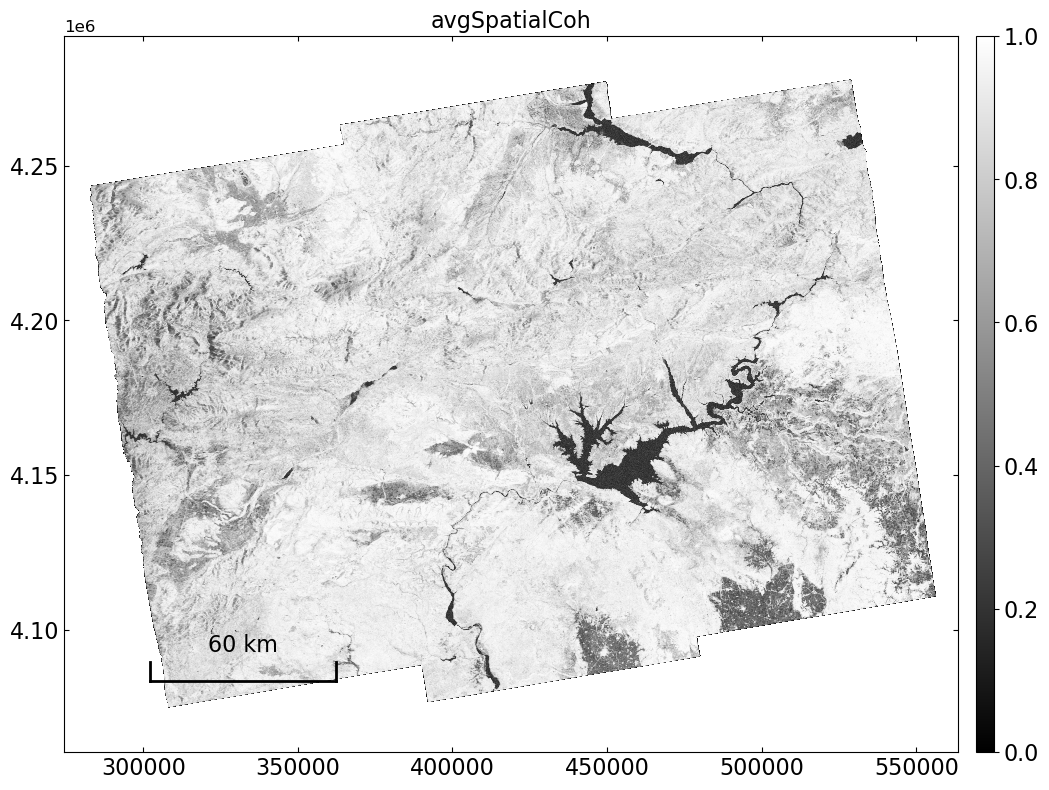

In [98]:
# Quality of the inversion
## Average spatial coherence

scp_args = f"{mint_path}/avgSpatialCoh.h5 --dpi 600 --figsize 12 12 --outfile {mint_path}/avg_spatial_coh.png"
view.main(scp_args.split()[:-2] + ['--noverbose', '--nodisplay'])
%matplotlib inline
view.main(scp_args.split())

view.py /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/temporalCoherence.h5 -v 0.6 1 --dpi 600 --figsize 8 8 --noverbose --nodisplay
run view.py in MintPy version 1.5.3, date 2023-11-23
input file is temporalCoherence file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/temporalCoherence.h5 in float32 format
file size in y/x: (2895, 3615)
num of datasets in file temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['temporalCoherence']
data   coverage in y/x: (0, 0, 3615, 2895)
subset coverage in y/x: (0, 0, 3615, 2895)
data   coverage in lat/lon: (274440.0, 4291960.0, 563640.0, 4060360.0)
subset coverage in lat/lon: (274440.0, 4291960.0, 563640.0, 4060360.0)
------------------------------------------------------------------------
colormap: gray
figure title: temporalCoherence
reading data ...
masking pixels with NO_DATA_VALUE of 0.0
data    range: [1.0, 1.0] 1
display range: [0.6, 1.0] 1
display data in transparency: 1.

<Figure size 800x800 with 0 Axes>

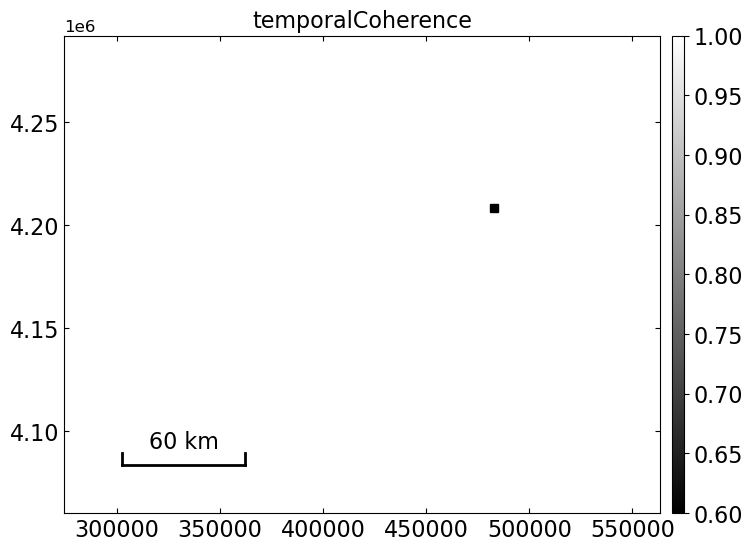

In [99]:
## Temporal coherence
### In addition to timeseries.h5 which contains the time-series dataset, invert_network produces other quantities, 
### which contain metrics to evaluate the quality of the inversion including temporalCoherence.h5. 
### Temporal coherence represents the consistency of the timeseries with the network of interferograms.
### Temporal coherence varies from 0 to 1. Pixels with values closer to 1 are considered reliable and pixels with 
### values closer to zero are considered unreliable. For a dense network of interferograms, a threshold of 0.7 may
### be used (Yunjun et al, 2019).

scp_args = f"{mint_path}/temporalCoherence.h5 -v 0.6 1 --dpi 600 --figsize 8 8 --outfile {mint_path}/temporal_coh.png"
view.main(scp_args.split()[:-2] + ['--noverbose', '--nodisplay'])
%matplotlib inline
view.main(scp_args.split())

view.py /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/velocity.h5 velocityStd -v 0 0.2 --dpi 600 --figsize 12 12 --noverbose --nodisplay
run view.py in MintPy version 1.5.3, date 2023-11-23
input file is velocity file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/velocity.h5 in float32 format
file size in y/x: (2895, 3615)
input dataset: "['velocityStd']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocityStd']
data   coverage in y/x: (0, 0, 3615, 2895)
subset coverage in y/x: (0, 0, 3615, 2895)
data   coverage in lat/lon: (274440.0, 4291960.0, 563640.0, 4060360.0)
subset coverage in lat/lon: (274440.0, 4291960.0, 563640.0, 4060360.0)
------------------------------------------------------------------------
colormap: jet
figure title: velocityStd
read mask from file: maskTempCoh.h5
reading data ...
masking data
masking pixels with NO_DATA_VALUE of 0.0

<Figure size 1200x1200 with 0 Axes>

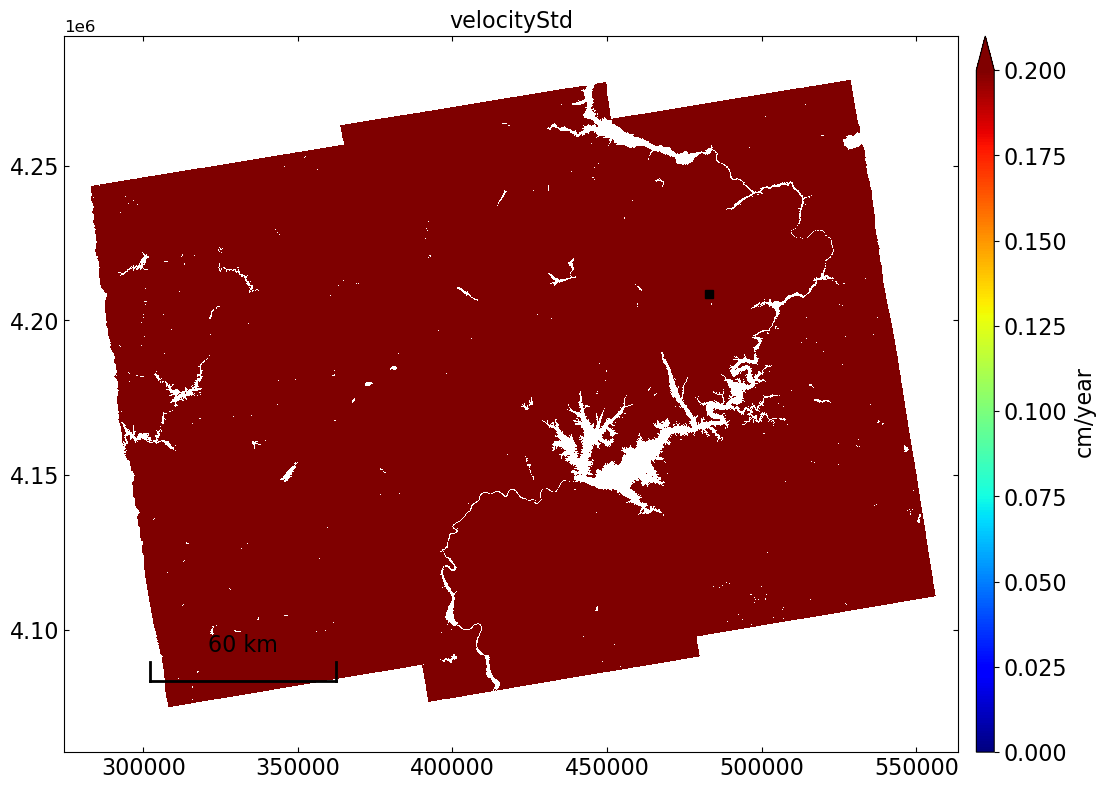

In [100]:
## Velocity error analysis

scp_args = f'{mint_path}/velocity.h5 velocityStd -v 0 0.2 --dpi 600 --figsize 12 12 --outfile {mint_path}/velocity_err.png'
# scp_args = f'{mint_path}/velocity.h5 interceptStd -v 0 0.5 --dpi 600 --figsize 12 12 --outfile {plot_path}/season_err.png'
view.main(scp_args.split()[:-2] + ['--noverbose', '--nodisplay'])
%matplotlib inline
view.main(scp_args.split())

#### 2. Visualization / convert files to pngs and geotiffs

In [102]:
# Create directories for geotiffs

geotiff_path = f'{mint_path}/GeoTiffs'
os.mkdir(path=geotiff_path)

disp_path = f'{geotiff_path}/displacement_maps'
os.mkdir(path=disp_path)

In [103]:
import h5py
import rasterio

ts_demErr = f'{mint_path}/timeseries_GACOS_demErr.h5'

with h5py.File(ts_demErr, "r") as f:
    dates = f["date"][()]
    date_list = [str(int(d)) for d in dates]
date_list
with h5py.File(ts_demErr, 'r') as f:
    unw_path = f.attrs['FILE_PATH']
ds_unw = rasterio.open(unw_path, 'r', driver='GTiff')

for i, d in enumerate(date_list):
    cmd = f'view.py {ts_demErr} {date_list[i]} --notitle --notick --noaxis'
    data, _, _ = prep_slice(cmd)
    data = data / 100 # cm -> meters
        
    with rasterio.open(f'{disp_path}/defo_{date_list[i]}.tif', 'w', driver='GTiff',
                  height = data.shape[0], width = data.shape[1],
                  count=1, dtype=str(data.dtype),
                  crs=ds_unw.read_crs(),
                  transform=ds_unw.transform,
                  nodata=np.nan) as ds:
        ds.write(data.astype(rasterio.float32), 1)

RasterioIOError: '/Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/timeseries_GACOS_demErr.h5' not recognized as a supported file format.

In [105]:
!save_gdal.py $mint_path/avgSpatialCoh.h5 --of GTIFF -o $geotiff_path/avgSpatialCoh.tif
!save_gdal.py $mint_path/temporalCoherence.h5 --of GTIFF -o $geotiff_path/TemporalCoherence.tif

read data from file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/avgSpatialCoh.h5
initiate GDAL driver: GeoTIFF
create raster band:
  raster row / column number: 2895, 3615
  raster data type: 6 (float32)
/Users/mtan/miniconda3/envs/mintpy/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
set transform info: (274440.0, 80.0, 0, 4291960.0, 0, -80.0)
set projection as: EPSG 32637
write data to raster band
finished writing to /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/GeoTiffs/avgSpatialCoh.tif
read data from file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/temporalCoherence.h5
initiate GDAL driver: GeoTIFF
create raster band:
  raster row / column number: 2895, 3615
  raster data type: 6 (float32)
/Users/mtan/miniconda3/envs/mintpy/lib/python3.11/sit

In [104]:
velocity_name = "velocity"
vel_h5 = os.path.join(mint_path, f'{velocity_name}.h5')
vel_msk_h5 = os.path.join(mint_path, f'{velocity_name}_msk.h5')
vel_tiff = os.path.join(geotiff_path, f'{velocity_name}_msk.tif')
temp_coh_msk_h5 = os.path.join(mint_path, 'maskTempCoh.h5')
#amp_tiff_tmp = geotiff_path/'season_amplitude_msk_tmp.tif'
#amp_tiff = geotiff_path/'season_amplitude_msk.tif'

!mask.py $vel_h5 -m $temp_coh_msk_h5
!save_gdal.py $vel_msk_h5 --of GTIFF -o $vel_tiff
#!save_gdal.py $vel_msk_h5 -d annualAmplitude --of GTIFF -o $amp_tiff_tmp
#!gdal_calc.py -A $amp_tiff_tmp --outfile=$amp_tiff --calc="A*2" --NoDataValue=0
#!rm $amp_tiff_tmp

masking velocity     from /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/velocity.h5 ...
masking velocityStd  from /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/velocity.h5 ...
masking intercept    from /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/velocity.h5 ...
masking interceptStd from /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/velocity.h5 ...
masking residue      from /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/velocity.h5 ...
delete exsited file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/velocity_msk.h5
create HDF5 file: /Users/mtan/Library/CloudStorage/OneDrive-DOI/data/mintpy/116hyp3IG/velocity_msk.h5 with w mode
create dataset /velocity     of float32    in size of (2895, 3615)         with compression=None
create dataset /velocityStd  of float32    in size of (2895, 3615)         with compression=None
create dataset /intercept    of float